In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchviz import make_dot
from tqdm.notebook import tqdm

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
# GPUメモリとCPUメモリの使い方確認（データが互いにCPU上にある場合の演算）
x_np = np.arange(-2.0, 2.1, 0.25)
y_np = np.arange(-1.0, 3.01, 0.25)
x = torch.tensor(x_np).float()
y = torch.tensor(y_np).float()
z = x * y
print(z)
print(z.device)

tensor([ 2.0000,  1.3125,  0.7500,  0.3125, -0.0000, -0.1875, -0.2500, -0.1875,
         0.0000,  0.3125,  0.7500,  1.3125,  2.0000,  2.8125,  3.7500,  4.8125,
         6.0000])
cpu


In [4]:
# GPUメモリとCPUメモリの使い方確認（データが互いにGPU上にある場合の演算）
x = x.to(device)
y = y.to(device)
z = x * y
print(z)
print(z.device)

tensor([ 2.0000,  1.3125,  0.7500,  0.3125, -0.0000, -0.1875, -0.2500, -0.1875,
         0.0000,  0.3125,  0.7500,  1.3125,  2.0000,  2.8125,  3.7500,  4.8125,
         6.0000], device='cuda:0')
cuda:0


In [5]:
# GPUメモリとCPUメモリの使い方確認（データの片方がGPUにあり，もう片方がCPUにある場合）
x_np = np.arange(-2.0, 2.1, 0.25)
y_np = np.arange(-1.0, 3.01, 0.25)
x = torch.tensor(x_np).float()
y = torch.tensor(y_np).float()
x = x.to(device)
z = x * y
print(z)
print(z.device)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

データの片方がGPUにありもう片方がCPUにある場合には，演算エラーが発生する

In [6]:
# MNISTデータセットの読み込み
data_root = '../data'

train_set0 = datasets.MNIST(
    root=data_root,
    train=True,
    download=True
)

100%|██████████| 9912422/9912422 [00:00<00:00, 107956052.95it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 85729436.54it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 73806509.89it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13202029.64it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [10]:
print('データ件数：', len(train_set0))
image, label = train_set0[0]
print('入力データの型：', type(image))
print('正解データの型：', type(label))

データ件数： 60000
入力データの型： <class 'PIL.Image.Image'>
正解データの型： <class 'int'>


(-0.5, 27.5, 27.5, -0.5)

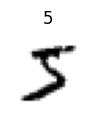

In [11]:
# 画像の表示
plt.figure(figsize=(1, 1))
plt.title(f'{label}')
plt.imshow(image, cmap='gray_r')
plt.axis('off')

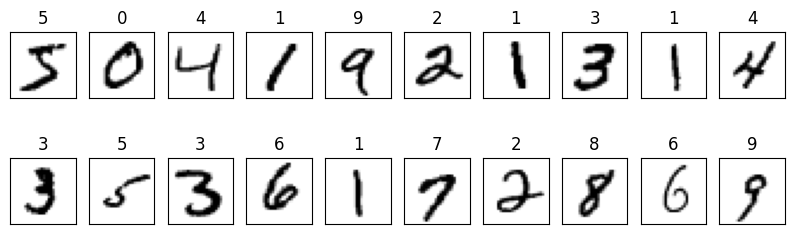

In [12]:
# 正解データ付きで，最初の20枚の画像を表示
plt.figure(figsize=(10, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)
    image, label = train_set0[i]
    plt.imshow(image, cmap='gray_r')
    ax.set_title(f'{label}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [14]:
# Transformを使ったデータの前処理
transform1 = transforms.Compose([
    transforms.ToTensor()
])
train_set1 = datasets.MNIST(
    root=data_root,
    train=True,
    download=True,
    transform=transform1
)

image, label = train_set1[0]
print('入力データの型：', type(image))
print('正解データの型：', type(label))
print('入力データのshape：', image.shape)
print('最小値：', image.min())
print('最大値：', image.max())

入力データの型： <class 'torch.Tensor'>
正解データの型： <class 'int'>
入力データのshape： torch.Size([1, 28, 28])
最小値： tensor(0.)
最大値： tensor(1.)


In [15]:
# Normalizeを使ったデータの正規化
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])
train_set2 = datasets.MNIST(
    root=data_root,
    train=True,
    download=True,
    transform=transform2
)

image, label = train_set2[0]
print('入力データの型：', type(image))
print('正解データの型：', type(label))
print('入力データのshape：', image.shape)
print('最小値：', image.min())
print('最大値：', image.max())

入力データの型： <class 'torch.Tensor'>
正解データの型： <class 'int'>
入力データのshape： torch.Size([1, 28, 28])
最小値： tensor(-1.)
最大値： tensor(1.)


In [16]:
# (1, 28, 28)の画像を(784)に変換
transform3 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1))
])
train_set3 = datasets.MNIST(
    root=data_root,
    train=True,
    download=True,
    transform=transform3
)

image, label = train_set3[0]
print('入力データの型：', type(image))
print('正解データの型：', type(label))
print('入力データのshape：', image.shape)
print('最小値：', image.min())
print('最大値：', image.max())

入力データの型： <class 'torch.Tensor'>
正解データの型： <class 'int'>
入力データのshape： torch.Size([784])
最小値： tensor(-1.)
最大値： tensor(1.)


In [17]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1))
])
train_set = datasets.MNIST(
    root=data_root,
    train=True,
    download=True,
    transform=transform
)
test_set = datasets.MNIST(
    root=data_root,
    train=False,
    download=True,
    transform=transform
)

In [19]:
# DataLoaderを使用したミニバッチ用データ生成
batch_size = 500

# 訓練データ用のDataLoader  
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True
)

# テストデータ用のDataLoader
# テストデータはシャッフルしない    
test_loader = DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False
)

In [20]:
# 何組のデータが取得できるか
print(len(train_loader))

# データローダーから最初の１セットを取得する
for images, labels in train_loader:
    break

print(images.shape)
print(labels.shape)

120
torch.Size([500, 784])
torch.Size([500])


In [26]:
# モデル定義
n_input = image.shape[0]
n_output = 10
n_hidden = 128

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_output)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

In [27]:
# 乱数の固定化
torch.manual_seed(123)
torch.cuda.manual_seed(123)

# モデルのインスタンス化
net = Net(n_input, n_output, n_hidden)

# モデルをGPUに転送
net.to(device)

Net(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)

In [28]:
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr)

In [29]:
for parameter in net.named_parameters():
    print(parameter)

('l1.weight', Parameter containing:
tensor([[-0.0146,  0.0012, -0.0177,  ...,  0.0277,  0.0200,  0.0315],
        [ 0.0184, -0.0322,  0.0175,  ...,  0.0089, -0.0028, -0.0033],
        [ 0.0092,  0.0261,  0.0075,  ...,  0.0061,  0.0267, -0.0258],
        ...,
        [ 0.0235, -0.0026, -0.0129,  ...,  0.0322, -0.0059, -0.0169],
        [-0.0328, -0.0258,  0.0124,  ..., -0.0049,  0.0006,  0.0334],
        [ 0.0187, -0.0076, -0.0202,  ...,  0.0325, -0.0159, -0.0240]],
       device='cuda:0', requires_grad=True))
('l1.bias', Parameter containing:
tensor([ 0.0325, -0.0298,  0.0013,  0.0199,  0.0268, -0.0248, -0.0172, -0.0355,
         0.0122, -0.0048,  0.0214,  0.0202, -0.0243,  0.0015, -0.0276,  0.0296,
         0.0341, -0.0228,  0.0230,  0.0347, -0.0091, -0.0346,  0.0206, -0.0060,
         0.0329,  0.0047,  0.0180,  0.0101,  0.0177, -0.0309,  0.0228, -0.0224,
         0.0321,  0.0179,  0.0321,  0.0184,  0.0219, -0.0089,  0.0310, -0.0039,
        -0.0074, -0.0317,  0.0192, -0.0021,  0.0190

In [30]:
print(net)

Net(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


tensor([[-2.4924e-01, -1.6401e-01,  6.6693e-02,  ...,  1.7774e-01,
          1.3926e-01,  3.1567e-02],
        [-2.2711e-01, -1.3490e-01,  1.8022e-01,  ...,  9.7160e-02,
          1.7953e-01,  2.3801e-01],
        [-4.6762e-01, -2.5788e-01, -3.1802e-04,  ...,  2.0369e-01,
         -2.2312e-02,  4.7357e-02],
        ...,
        [-1.9138e-01, -1.5731e-01,  1.7582e-01,  ...,  1.0740e-01,
          8.9498e-02,  2.4380e-01],
        [-1.9811e-01, -1.8618e-01,  5.8497e-02,  ...,  1.6977e-01,
          1.1300e-01,  6.5241e-02],
        [-2.1888e-01, -2.0265e-01,  3.1892e-02,  ...,  6.6172e-02,
          1.4536e-01,  6.7785e-02]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(2.3330, device='cuda:0', grad_fn=<NllLossBackward0>)


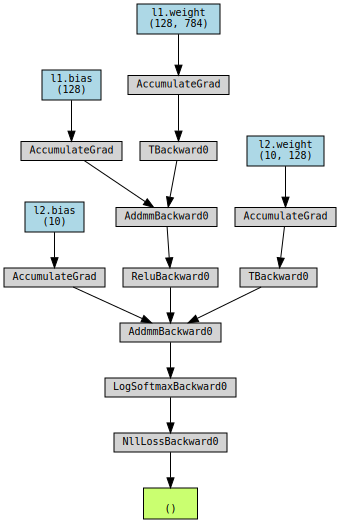

In [34]:
# 1エポック分の学習
for images, labels in train_loader:
    break
inputs = images.to(device)
labels = labels.to(device)
outputs = net(inputs)
print(outputs)

loss = criterion(outputs, labels)
print(loss)
make_dot(loss, params=dict(net.named_parameters()))

In [38]:
# 乱数の固定化
torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

lr = 0.01
net = Net(n_input, n_output, n_hidden)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr)
num_epochs = 100

net = net.to(device)

history = np.zeros((0, 5))

for epoch in range(num_epochs):
    # 1エポックあたりの正解数(精度計算用)
    n_train_acc, n_val_acc = 0, 0
    # 1エポックあたりの累積損失(平均化前)
    train_loss, val_loss = 0, 0
    # 1エポックあたりのデータ累積件数
    n_train, n_test = 0, 0

    for inputs, labels in tqdm(train_loader):
        # 1バッチあたりのデータ件数
        train_batch_size = len(labels)
        # 1エポックあたりのデータ累積件数
        n_train += train_batch_size

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        
        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        train_loss = loss.item()

        predicted = torch.max(outputs, 1)[1]

        train_loss = loss.item() * train_batch_size     # lossは平均計算が行われているので平均前の損失に戻して加算
        n_train_acc += (predicted == labels).sum().item()   # 1エポックあたりの正解数の合計を計算するために加算

        with torch.no_grad():
            for inputs_test, labels_test in test_loader:
                test_batch_size = len(labels_test)
                n_test += test_batch_size

                inputs_test = inputs_test.to(device)
                labels_test = labels_test.to(device)

                outputs_test = net(inputs_test)

                loss_test = criterion(outputs_test, labels_test)

                predicted_test = torch.max(outputs_test, 1)[1]

                val_loss += loss_test.item() * test_batch_size  # lossは平均計算が行われているので平均前の損失に戻して加算
                n_val_acc += (predicted_test == labels_test).sum().item()   # 1エポックあたりの正解数の合計を計算するために加算

        # 精度計算
        train_acc = n_train_acc / n_train
        val_acc = n_val_acc / n_test
        # 損失計算
        ave_train_loss = train_loss / n_train
        ave_val_loss = val_loss / n_test

        # 結果表示
        print(f'epoch: {epoch + 1}, loss: {ave_train_loss:.4f}, accuracy: {train_acc:.4f}, val_loss: {ave_val_loss:.4f}, val_accuracy: {val_acc:.4f}')
        # 結果記録
        history = np.vstack((history, np.array([epoch, ave_train_loss, train_acc, ave_val_loss, val_acc])))


  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 1, loss: 2.3260, accuracy: 0.0740, val_loss: 2.3135, val_accuracy: 0.0974
epoch: 1, loss: 1.1587, accuracy: 0.0760, val_loss: 2.3084, val_accuracy: 0.1017
epoch: 1, loss: 0.7695, accuracy: 0.0840, val_loss: 2.3036, val_accuracy: 0.1057
epoch: 1, loss: 0.5727, accuracy: 0.0950, val_loss: 2.2990, val_accuracy: 0.1094
epoch: 1, loss: 0.4569, accuracy: 0.1012, val_loss: 2.2945, val_accuracy: 0.1136
epoch: 1, loss: 0.3801, accuracy: 0.1067, val_loss: 2.2901, val_accuracy: 0.1184
epoch: 1, loss: 0.3240, accuracy: 0.1114, val_loss: 2.2857, val_accuracy: 0.1232
epoch: 1, loss: 0.2847, accuracy: 0.1148, val_loss: 2.2813, val_accuracy: 0.1285
epoch: 1, loss: 0.2509, accuracy: 0.1211, val_loss: 2.2771, val_accuracy: 0.1345
epoch: 1, loss: 0.2239, accuracy: 0.1280, val_loss: 2.2728, val_accuracy: 0.1427
epoch: 1, loss: 0.2037, accuracy: 0.1347, val_loss: 2.2685, val_accuracy: 0.1530
epoch: 1, loss: 0.1867, accuracy: 0.1417, val_loss: 2.2644, val_accuracy: 0.1627
epoch: 1, loss: 0.1715, accu

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 2, loss: 1.3286, accuracy: 0.7440, val_loss: 1.3195, val_accuracy: 0.7476
epoch: 2, loss: 0.6679, accuracy: 0.7370, val_loss: 1.3161, val_accuracy: 0.7478
epoch: 2, loss: 0.4527, accuracy: 0.7307, val_loss: 1.3126, val_accuracy: 0.7502
epoch: 2, loss: 0.3239, accuracy: 0.7410, val_loss: 1.3090, val_accuracy: 0.7525
epoch: 2, loss: 0.2587, accuracy: 0.7460, val_loss: 1.3056, val_accuracy: 0.7530
epoch: 2, loss: 0.2221, accuracy: 0.7403, val_loss: 1.3023, val_accuracy: 0.7541
epoch: 2, loss: 0.1822, accuracy: 0.7411, val_loss: 1.2988, val_accuracy: 0.7562
epoch: 2, loss: 0.1601, accuracy: 0.7428, val_loss: 1.2953, val_accuracy: 0.7573
epoch: 2, loss: 0.1440, accuracy: 0.7433, val_loss: 1.2920, val_accuracy: 0.7586
epoch: 2, loss: 0.1304, accuracy: 0.7418, val_loss: 1.2886, val_accuracy: 0.7594
epoch: 2, loss: 0.1168, accuracy: 0.7416, val_loss: 1.2853, val_accuracy: 0.7607
epoch: 2, loss: 0.1074, accuracy: 0.7422, val_loss: 1.2819, val_accuracy: 0.7616
epoch: 2, loss: 0.0980, accu

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 3, loss: 0.7905, accuracy: 0.8500, val_loss: 0.7948, val_accuracy: 0.8325
epoch: 3, loss: 0.4160, accuracy: 0.8400, val_loss: 0.7933, val_accuracy: 0.8337
epoch: 3, loss: 0.2665, accuracy: 0.8300, val_loss: 0.7921, val_accuracy: 0.8338
epoch: 3, loss: 0.1980, accuracy: 0.8365, val_loss: 0.7908, val_accuracy: 0.8339
epoch: 3, loss: 0.1631, accuracy: 0.8316, val_loss: 0.7894, val_accuracy: 0.8342
epoch: 3, loss: 0.1361, accuracy: 0.8310, val_loss: 0.7882, val_accuracy: 0.8344
epoch: 3, loss: 0.1179, accuracy: 0.8274, val_loss: 0.7870, val_accuracy: 0.8344
epoch: 3, loss: 0.1023, accuracy: 0.8273, val_loss: 0.7858, val_accuracy: 0.8349
epoch: 3, loss: 0.0873, accuracy: 0.8278, val_loss: 0.7846, val_accuracy: 0.8353
epoch: 3, loss: 0.0872, accuracy: 0.8246, val_loss: 0.7834, val_accuracy: 0.8356
epoch: 3, loss: 0.0718, accuracy: 0.8256, val_loss: 0.7824, val_accuracy: 0.8358
epoch: 3, loss: 0.0674, accuracy: 0.8262, val_loss: 0.7813, val_accuracy: 0.8360
epoch: 3, loss: 0.0601, accu

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 4, loss: 0.6109, accuracy: 0.8500, val_loss: 0.6023, val_accuracy: 0.8593
epoch: 4, loss: 0.3202, accuracy: 0.8470, val_loss: 0.6018, val_accuracy: 0.8593
epoch: 4, loss: 0.2093, accuracy: 0.8513, val_loss: 0.6013, val_accuracy: 0.8594
epoch: 4, loss: 0.1478, accuracy: 0.8550, val_loss: 0.6008, val_accuracy: 0.8597
epoch: 4, loss: 0.1261, accuracy: 0.8560, val_loss: 0.6003, val_accuracy: 0.8598
epoch: 4, loss: 0.1109, accuracy: 0.8540, val_loss: 0.5998, val_accuracy: 0.8595
epoch: 4, loss: 0.0996, accuracy: 0.8509, val_loss: 0.5993, val_accuracy: 0.8595
epoch: 4, loss: 0.0747, accuracy: 0.8515, val_loss: 0.5988, val_accuracy: 0.8597
epoch: 4, loss: 0.0579, accuracy: 0.8558, val_loss: 0.5983, val_accuracy: 0.8597
epoch: 4, loss: 0.0642, accuracy: 0.8546, val_loss: 0.5978, val_accuracy: 0.8598
epoch: 4, loss: 0.0541, accuracy: 0.8553, val_loss: 0.5973, val_accuracy: 0.8599
epoch: 4, loss: 0.0518, accuracy: 0.8550, val_loss: 0.5968, val_accuracy: 0.8600
epoch: 4, loss: 0.0445, accu

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 5, loss: 0.5722, accuracy: 0.8540, val_loss: 0.5118, val_accuracy: 0.8735
epoch: 5, loss: 0.2373, accuracy: 0.8790, val_loss: 0.5114, val_accuracy: 0.8725
epoch: 5, loss: 0.1861, accuracy: 0.8720, val_loss: 0.5108, val_accuracy: 0.8724
epoch: 5, loss: 0.1442, accuracy: 0.8660, val_loss: 0.5103, val_accuracy: 0.8725
epoch: 5, loss: 0.1021, accuracy: 0.8676, val_loss: 0.5099, val_accuracy: 0.8724
epoch: 5, loss: 0.0902, accuracy: 0.8653, val_loss: 0.5094, val_accuracy: 0.8724
epoch: 5, loss: 0.0727, accuracy: 0.8674, val_loss: 0.5091, val_accuracy: 0.8723
epoch: 5, loss: 0.0599, accuracy: 0.8692, val_loss: 0.5087, val_accuracy: 0.8722
epoch: 5, loss: 0.0582, accuracy: 0.8691, val_loss: 0.5084, val_accuracy: 0.8724
epoch: 5, loss: 0.0505, accuracy: 0.8714, val_loss: 0.5082, val_accuracy: 0.8724
epoch: 5, loss: 0.0483, accuracy: 0.8693, val_loss: 0.5080, val_accuracy: 0.8725
epoch: 5, loss: 0.0443, accuracy: 0.8677, val_loss: 0.5077, val_accuracy: 0.8726
epoch: 5, loss: 0.0443, accu

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 6, loss: 0.4641, accuracy: 0.8880, val_loss: 0.4577, val_accuracy: 0.8793
epoch: 6, loss: 0.2386, accuracy: 0.8710, val_loss: 0.4576, val_accuracy: 0.8800
epoch: 6, loss: 0.1736, accuracy: 0.8667, val_loss: 0.4575, val_accuracy: 0.8803
epoch: 6, loss: 0.1230, accuracy: 0.8645, val_loss: 0.4576, val_accuracy: 0.8802
epoch: 6, loss: 0.0945, accuracy: 0.8664, val_loss: 0.4575, val_accuracy: 0.8803
epoch: 6, loss: 0.0749, accuracy: 0.8667, val_loss: 0.4574, val_accuracy: 0.8804
epoch: 6, loss: 0.0623, accuracy: 0.8691, val_loss: 0.4573, val_accuracy: 0.8805
epoch: 6, loss: 0.0589, accuracy: 0.8692, val_loss: 0.4572, val_accuracy: 0.8805
epoch: 6, loss: 0.0486, accuracy: 0.8713, val_loss: 0.4570, val_accuracy: 0.8806
epoch: 6, loss: 0.0468, accuracy: 0.8726, val_loss: 0.4568, val_accuracy: 0.8806
epoch: 6, loss: 0.0424, accuracy: 0.8735, val_loss: 0.4566, val_accuracy: 0.8806
epoch: 6, loss: 0.0454, accuracy: 0.8722, val_loss: 0.4564, val_accuracy: 0.8807
epoch: 6, loss: 0.0394, accu

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 7, loss: 0.4282, accuracy: 0.8780, val_loss: 0.4240, val_accuracy: 0.8863
epoch: 7, loss: 0.2076, accuracy: 0.8920, val_loss: 0.4237, val_accuracy: 0.8861
epoch: 7, loss: 0.1281, accuracy: 0.8967, val_loss: 0.4235, val_accuracy: 0.8861
epoch: 7, loss: 0.1040, accuracy: 0.8970, val_loss: 0.4233, val_accuracy: 0.8859
epoch: 7, loss: 0.0870, accuracy: 0.8920, val_loss: 0.4232, val_accuracy: 0.8859
epoch: 7, loss: 0.0741, accuracy: 0.8913, val_loss: 0.4231, val_accuracy: 0.8858
epoch: 7, loss: 0.0687, accuracy: 0.8880, val_loss: 0.4231, val_accuracy: 0.8859
epoch: 7, loss: 0.0529, accuracy: 0.8882, val_loss: 0.4230, val_accuracy: 0.8858
epoch: 7, loss: 0.0466, accuracy: 0.8902, val_loss: 0.4228, val_accuracy: 0.8858
epoch: 7, loss: 0.0427, accuracy: 0.8906, val_loss: 0.4227, val_accuracy: 0.8859
epoch: 7, loss: 0.0377, accuracy: 0.8898, val_loss: 0.4225, val_accuracy: 0.8860
epoch: 7, loss: 0.0309, accuracy: 0.8927, val_loss: 0.4225, val_accuracy: 0.8861
epoch: 7, loss: 0.0352, accu

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 8, loss: 0.3252, accuracy: 0.9040, val_loss: 0.3995, val_accuracy: 0.8903
epoch: 8, loss: 0.2198, accuracy: 0.8880, val_loss: 0.3998, val_accuracy: 0.8902
epoch: 8, loss: 0.1351, accuracy: 0.8907, val_loss: 0.3999, val_accuracy: 0.8900
epoch: 8, loss: 0.1049, accuracy: 0.8915, val_loss: 0.3998, val_accuracy: 0.8901
epoch: 8, loss: 0.0968, accuracy: 0.8868, val_loss: 0.3998, val_accuracy: 0.8901
epoch: 8, loss: 0.0705, accuracy: 0.8857, val_loss: 0.3998, val_accuracy: 0.8901
epoch: 8, loss: 0.0532, accuracy: 0.8877, val_loss: 0.3998, val_accuracy: 0.8902
epoch: 8, loss: 0.0476, accuracy: 0.8875, val_loss: 0.3999, val_accuracy: 0.8900
epoch: 8, loss: 0.0464, accuracy: 0.8882, val_loss: 0.3999, val_accuracy: 0.8899
epoch: 8, loss: 0.0379, accuracy: 0.8882, val_loss: 0.3997, val_accuracy: 0.8900
epoch: 8, loss: 0.0362, accuracy: 0.8885, val_loss: 0.3996, val_accuracy: 0.8900
epoch: 8, loss: 0.0293, accuracy: 0.8903, val_loss: 0.3995, val_accuracy: 0.8900
epoch: 8, loss: 0.0332, accu

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 9, loss: 0.3063, accuracy: 0.9420, val_loss: 0.3817, val_accuracy: 0.8936
epoch: 9, loss: 0.2113, accuracy: 0.9100, val_loss: 0.3819, val_accuracy: 0.8938
epoch: 9, loss: 0.1328, accuracy: 0.9020, val_loss: 0.3821, val_accuracy: 0.8937
epoch: 9, loss: 0.0939, accuracy: 0.9000, val_loss: 0.3821, val_accuracy: 0.8936
epoch: 9, loss: 0.0783, accuracy: 0.9004, val_loss: 0.3820, val_accuracy: 0.8935
epoch: 9, loss: 0.0783, accuracy: 0.8967, val_loss: 0.3819, val_accuracy: 0.8935
epoch: 9, loss: 0.0505, accuracy: 0.8971, val_loss: 0.3819, val_accuracy: 0.8935
epoch: 9, loss: 0.0545, accuracy: 0.8945, val_loss: 0.3818, val_accuracy: 0.8936
epoch: 9, loss: 0.0407, accuracy: 0.8969, val_loss: 0.3817, val_accuracy: 0.8937
epoch: 9, loss: 0.0436, accuracy: 0.8948, val_loss: 0.3817, val_accuracy: 0.8937
epoch: 9, loss: 0.0387, accuracy: 0.8936, val_loss: 0.3816, val_accuracy: 0.8937
epoch: 9, loss: 0.0368, accuracy: 0.8927, val_loss: 0.3816, val_accuracy: 0.8938
epoch: 9, loss: 0.0275, accu

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 10, loss: 0.4430, accuracy: 0.8740, val_loss: 0.3683, val_accuracy: 0.8965
epoch: 10, loss: 0.2017, accuracy: 0.8800, val_loss: 0.3683, val_accuracy: 0.8967
epoch: 10, loss: 0.1203, accuracy: 0.8913, val_loss: 0.3684, val_accuracy: 0.8967
epoch: 10, loss: 0.0843, accuracy: 0.8950, val_loss: 0.3684, val_accuracy: 0.8967
epoch: 10, loss: 0.0796, accuracy: 0.8908, val_loss: 0.3683, val_accuracy: 0.8967
epoch: 10, loss: 0.0670, accuracy: 0.8870, val_loss: 0.3683, val_accuracy: 0.8969
epoch: 10, loss: 0.0504, accuracy: 0.8903, val_loss: 0.3683, val_accuracy: 0.8970
epoch: 10, loss: 0.0454, accuracy: 0.8930, val_loss: 0.3682, val_accuracy: 0.8972
epoch: 10, loss: 0.0432, accuracy: 0.8920, val_loss: 0.3682, val_accuracy: 0.8972
epoch: 10, loss: 0.0381, accuracy: 0.8902, val_loss: 0.3682, val_accuracy: 0.8972
epoch: 10, loss: 0.0340, accuracy: 0.8907, val_loss: 0.3681, val_accuracy: 0.8972
epoch: 10, loss: 0.0302, accuracy: 0.8910, val_loss: 0.3680, val_accuracy: 0.8971
epoch: 10, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 11, loss: 0.3814, accuracy: 0.8960, val_loss: 0.3582, val_accuracy: 0.8998
epoch: 11, loss: 0.1783, accuracy: 0.9000, val_loss: 0.3579, val_accuracy: 0.8992
epoch: 11, loss: 0.1208, accuracy: 0.9000, val_loss: 0.3579, val_accuracy: 0.8991
epoch: 11, loss: 0.0839, accuracy: 0.9035, val_loss: 0.3578, val_accuracy: 0.8990
epoch: 11, loss: 0.0609, accuracy: 0.9036, val_loss: 0.3577, val_accuracy: 0.8990
epoch: 11, loss: 0.0624, accuracy: 0.9023, val_loss: 0.3576, val_accuracy: 0.8989
epoch: 11, loss: 0.0552, accuracy: 0.9003, val_loss: 0.3576, val_accuracy: 0.8989
epoch: 11, loss: 0.0417, accuracy: 0.8998, val_loss: 0.3576, val_accuracy: 0.8989
epoch: 11, loss: 0.0502, accuracy: 0.8953, val_loss: 0.3576, val_accuracy: 0.8989
epoch: 11, loss: 0.0335, accuracy: 0.8972, val_loss: 0.3575, val_accuracy: 0.8990
epoch: 11, loss: 0.0374, accuracy: 0.8956, val_loss: 0.3574, val_accuracy: 0.8990
epoch: 11, loss: 0.0322, accuracy: 0.8948, val_loss: 0.3573, val_accuracy: 0.8990
epoch: 11, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 12, loss: 0.3998, accuracy: 0.8640, val_loss: 0.3479, val_accuracy: 0.9008
epoch: 12, loss: 0.1605, accuracy: 0.8840, val_loss: 0.3480, val_accuracy: 0.9010
epoch: 12, loss: 0.1304, accuracy: 0.8880, val_loss: 0.3483, val_accuracy: 0.9011
epoch: 12, loss: 0.1151, accuracy: 0.8845, val_loss: 0.3483, val_accuracy: 0.9011
epoch: 12, loss: 0.0604, accuracy: 0.8904, val_loss: 0.3484, val_accuracy: 0.9013
epoch: 12, loss: 0.0713, accuracy: 0.8883, val_loss: 0.3487, val_accuracy: 0.9014
epoch: 12, loss: 0.0503, accuracy: 0.8897, val_loss: 0.3488, val_accuracy: 0.9013
epoch: 12, loss: 0.0434, accuracy: 0.8925, val_loss: 0.3487, val_accuracy: 0.9015
epoch: 12, loss: 0.0423, accuracy: 0.8911, val_loss: 0.3486, val_accuracy: 0.9015
epoch: 12, loss: 0.0373, accuracy: 0.8900, val_loss: 0.3485, val_accuracy: 0.9015
epoch: 12, loss: 0.0319, accuracy: 0.8915, val_loss: 0.3484, val_accuracy: 0.9015
epoch: 12, loss: 0.0323, accuracy: 0.8918, val_loss: 0.3483, val_accuracy: 0.9015
epoch: 12, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 13, loss: 0.3191, accuracy: 0.9180, val_loss: 0.3418, val_accuracy: 0.9033
epoch: 13, loss: 0.1815, accuracy: 0.9040, val_loss: 0.3413, val_accuracy: 0.9034
epoch: 13, loss: 0.1138, accuracy: 0.9053, val_loss: 0.3410, val_accuracy: 0.9035
epoch: 13, loss: 0.0863, accuracy: 0.9020, val_loss: 0.3407, val_accuracy: 0.9036
epoch: 13, loss: 0.0743, accuracy: 0.8996, val_loss: 0.3405, val_accuracy: 0.9036
epoch: 13, loss: 0.0619, accuracy: 0.8977, val_loss: 0.3404, val_accuracy: 0.9037
epoch: 13, loss: 0.0497, accuracy: 0.8974, val_loss: 0.3403, val_accuracy: 0.9038
epoch: 13, loss: 0.0338, accuracy: 0.9002, val_loss: 0.3402, val_accuracy: 0.9037
epoch: 13, loss: 0.0414, accuracy: 0.9011, val_loss: 0.3402, val_accuracy: 0.9037
epoch: 13, loss: 0.0364, accuracy: 0.8992, val_loss: 0.3402, val_accuracy: 0.9038
epoch: 13, loss: 0.0263, accuracy: 0.9024, val_loss: 0.3402, val_accuracy: 0.9036
epoch: 13, loss: 0.0273, accuracy: 0.9025, val_loss: 0.3401, val_accuracy: 0.9036
epoch: 13, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 14, loss: 0.3307, accuracy: 0.9060, val_loss: 0.3345, val_accuracy: 0.9043
epoch: 14, loss: 0.1459, accuracy: 0.9100, val_loss: 0.3345, val_accuracy: 0.9046
epoch: 14, loss: 0.1061, accuracy: 0.9133, val_loss: 0.3345, val_accuracy: 0.9049
epoch: 14, loss: 0.0929, accuracy: 0.9095, val_loss: 0.3344, val_accuracy: 0.9050
epoch: 14, loss: 0.0633, accuracy: 0.9092, val_loss: 0.3344, val_accuracy: 0.9050
epoch: 14, loss: 0.0620, accuracy: 0.9040, val_loss: 0.3347, val_accuracy: 0.9051
epoch: 14, loss: 0.0481, accuracy: 0.9049, val_loss: 0.3347, val_accuracy: 0.9051
epoch: 14, loss: 0.0366, accuracy: 0.9080, val_loss: 0.3347, val_accuracy: 0.9053
epoch: 14, loss: 0.0406, accuracy: 0.9053, val_loss: 0.3346, val_accuracy: 0.9053
epoch: 14, loss: 0.0373, accuracy: 0.9030, val_loss: 0.3346, val_accuracy: 0.9054
epoch: 14, loss: 0.0325, accuracy: 0.9042, val_loss: 0.3346, val_accuracy: 0.9054
epoch: 14, loss: 0.0282, accuracy: 0.9033, val_loss: 0.3346, val_accuracy: 0.9053
epoch: 14, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 15, loss: 0.3627, accuracy: 0.8840, val_loss: 0.3291, val_accuracy: 0.9066
epoch: 15, loss: 0.1488, accuracy: 0.9010, val_loss: 0.3290, val_accuracy: 0.9067
epoch: 15, loss: 0.1058, accuracy: 0.9067, val_loss: 0.3288, val_accuracy: 0.9065
epoch: 15, loss: 0.0667, accuracy: 0.9130, val_loss: 0.3287, val_accuracy: 0.9063
epoch: 15, loss: 0.0671, accuracy: 0.9080, val_loss: 0.3286, val_accuracy: 0.9061
epoch: 15, loss: 0.0506, accuracy: 0.9103, val_loss: 0.3285, val_accuracy: 0.9061
epoch: 15, loss: 0.0530, accuracy: 0.9086, val_loss: 0.3284, val_accuracy: 0.9060
epoch: 15, loss: 0.0329, accuracy: 0.9100, val_loss: 0.3283, val_accuracy: 0.9059
epoch: 15, loss: 0.0376, accuracy: 0.9078, val_loss: 0.3282, val_accuracy: 0.9059
epoch: 15, loss: 0.0387, accuracy: 0.9058, val_loss: 0.3282, val_accuracy: 0.9058
epoch: 15, loss: 0.0313, accuracy: 0.9042, val_loss: 0.3282, val_accuracy: 0.9057
epoch: 15, loss: 0.0284, accuracy: 0.9032, val_loss: 0.3281, val_accuracy: 0.9058
epoch: 15, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 16, loss: 0.3231, accuracy: 0.9060, val_loss: 0.3233, val_accuracy: 0.9086
epoch: 16, loss: 0.1838, accuracy: 0.8980, val_loss: 0.3233, val_accuracy: 0.9083
epoch: 16, loss: 0.1351, accuracy: 0.8980, val_loss: 0.3233, val_accuracy: 0.9083
epoch: 16, loss: 0.0953, accuracy: 0.8945, val_loss: 0.3233, val_accuracy: 0.9078
epoch: 16, loss: 0.0696, accuracy: 0.8924, val_loss: 0.3234, val_accuracy: 0.9074
epoch: 16, loss: 0.0606, accuracy: 0.8940, val_loss: 0.3233, val_accuracy: 0.9074
epoch: 16, loss: 0.0488, accuracy: 0.8934, val_loss: 0.3232, val_accuracy: 0.9075
epoch: 16, loss: 0.0397, accuracy: 0.8958, val_loss: 0.3231, val_accuracy: 0.9076
epoch: 16, loss: 0.0351, accuracy: 0.8982, val_loss: 0.3231, val_accuracy: 0.9075
epoch: 16, loss: 0.0330, accuracy: 0.8996, val_loss: 0.3231, val_accuracy: 0.9075
epoch: 16, loss: 0.0231, accuracy: 0.9024, val_loss: 0.3230, val_accuracy: 0.9076
epoch: 16, loss: 0.0323, accuracy: 0.9010, val_loss: 0.3230, val_accuracy: 0.9076
epoch: 16, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 17, loss: 0.2808, accuracy: 0.9160, val_loss: 0.3194, val_accuracy: 0.9075
epoch: 17, loss: 0.1641, accuracy: 0.9180, val_loss: 0.3194, val_accuracy: 0.9073
epoch: 17, loss: 0.1185, accuracy: 0.9113, val_loss: 0.3190, val_accuracy: 0.9074
epoch: 17, loss: 0.0801, accuracy: 0.9085, val_loss: 0.3188, val_accuracy: 0.9076
epoch: 17, loss: 0.0571, accuracy: 0.9096, val_loss: 0.3185, val_accuracy: 0.9077
epoch: 17, loss: 0.0543, accuracy: 0.9070, val_loss: 0.3185, val_accuracy: 0.9079
epoch: 17, loss: 0.0476, accuracy: 0.9066, val_loss: 0.3184, val_accuracy: 0.9079
epoch: 17, loss: 0.0391, accuracy: 0.9067, val_loss: 0.3183, val_accuracy: 0.9081
epoch: 17, loss: 0.0406, accuracy: 0.9071, val_loss: 0.3182, val_accuracy: 0.9081
epoch: 17, loss: 0.0332, accuracy: 0.9078, val_loss: 0.3181, val_accuracy: 0.9082
epoch: 17, loss: 0.0299, accuracy: 0.9080, val_loss: 0.3180, val_accuracy: 0.9082
epoch: 17, loss: 0.0236, accuracy: 0.9100, val_loss: 0.3180, val_accuracy: 0.9083
epoch: 17, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 18, loss: 0.3323, accuracy: 0.9040, val_loss: 0.3138, val_accuracy: 0.9107
epoch: 18, loss: 0.1440, accuracy: 0.9130, val_loss: 0.3136, val_accuracy: 0.9105
epoch: 18, loss: 0.1277, accuracy: 0.9007, val_loss: 0.3136, val_accuracy: 0.9104
epoch: 18, loss: 0.0922, accuracy: 0.9030, val_loss: 0.3137, val_accuracy: 0.9105
epoch: 18, loss: 0.0595, accuracy: 0.9048, val_loss: 0.3138, val_accuracy: 0.9105
epoch: 18, loss: 0.0655, accuracy: 0.9037, val_loss: 0.3138, val_accuracy: 0.9106
epoch: 18, loss: 0.0463, accuracy: 0.9040, val_loss: 0.3138, val_accuracy: 0.9106
epoch: 18, loss: 0.0403, accuracy: 0.9042, val_loss: 0.3137, val_accuracy: 0.9105
epoch: 18, loss: 0.0382, accuracy: 0.9024, val_loss: 0.3137, val_accuracy: 0.9105
epoch: 18, loss: 0.0311, accuracy: 0.9044, val_loss: 0.3136, val_accuracy: 0.9106
epoch: 18, loss: 0.0311, accuracy: 0.9038, val_loss: 0.3136, val_accuracy: 0.9106
epoch: 18, loss: 0.0233, accuracy: 0.9055, val_loss: 0.3137, val_accuracy: 0.9106
epoch: 18, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 19, loss: 0.3598, accuracy: 0.8760, val_loss: 0.3107, val_accuracy: 0.9101
epoch: 19, loss: 0.1483, accuracy: 0.8970, val_loss: 0.3106, val_accuracy: 0.9106
epoch: 19, loss: 0.1168, accuracy: 0.8947, val_loss: 0.3104, val_accuracy: 0.9107
epoch: 19, loss: 0.1021, accuracy: 0.8885, val_loss: 0.3103, val_accuracy: 0.9110
epoch: 19, loss: 0.0612, accuracy: 0.8924, val_loss: 0.3102, val_accuracy: 0.9110
epoch: 19, loss: 0.0548, accuracy: 0.8943, val_loss: 0.3102, val_accuracy: 0.9108
epoch: 19, loss: 0.0407, accuracy: 0.8977, val_loss: 0.3102, val_accuracy: 0.9110
epoch: 19, loss: 0.0403, accuracy: 0.8978, val_loss: 0.3102, val_accuracy: 0.9110
epoch: 19, loss: 0.0343, accuracy: 0.8987, val_loss: 0.3102, val_accuracy: 0.9111
epoch: 19, loss: 0.0293, accuracy: 0.9004, val_loss: 0.3102, val_accuracy: 0.9110
epoch: 19, loss: 0.0320, accuracy: 0.9000, val_loss: 0.3101, val_accuracy: 0.9110
epoch: 19, loss: 0.0248, accuracy: 0.9012, val_loss: 0.3101, val_accuracy: 0.9110
epoch: 19, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 20, loss: 0.2964, accuracy: 0.9160, val_loss: 0.3064, val_accuracy: 0.9133
epoch: 20, loss: 0.1633, accuracy: 0.9110, val_loss: 0.3066, val_accuracy: 0.9133
epoch: 20, loss: 0.1205, accuracy: 0.8993, val_loss: 0.3066, val_accuracy: 0.9133
epoch: 20, loss: 0.0753, accuracy: 0.9050, val_loss: 0.3068, val_accuracy: 0.9132
epoch: 20, loss: 0.0810, accuracy: 0.9024, val_loss: 0.3067, val_accuracy: 0.9128
epoch: 20, loss: 0.0493, accuracy: 0.9053, val_loss: 0.3067, val_accuracy: 0.9125
epoch: 20, loss: 0.0462, accuracy: 0.9040, val_loss: 0.3068, val_accuracy: 0.9124
epoch: 20, loss: 0.0377, accuracy: 0.9055, val_loss: 0.3069, val_accuracy: 0.9124
epoch: 20, loss: 0.0365, accuracy: 0.9040, val_loss: 0.3070, val_accuracy: 0.9124
epoch: 20, loss: 0.0264, accuracy: 0.9058, val_loss: 0.3070, val_accuracy: 0.9122
epoch: 20, loss: 0.0273, accuracy: 0.9062, val_loss: 0.3069, val_accuracy: 0.9122
epoch: 20, loss: 0.0259, accuracy: 0.9052, val_loss: 0.3069, val_accuracy: 0.9121
epoch: 20, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 21, loss: 0.3465, accuracy: 0.9040, val_loss: 0.3030, val_accuracy: 0.9139
epoch: 21, loss: 0.1769, accuracy: 0.8980, val_loss: 0.3029, val_accuracy: 0.9136
epoch: 21, loss: 0.0860, accuracy: 0.9067, val_loss: 0.3029, val_accuracy: 0.9135
epoch: 21, loss: 0.0737, accuracy: 0.9105, val_loss: 0.3030, val_accuracy: 0.9131
epoch: 21, loss: 0.0615, accuracy: 0.9112, val_loss: 0.3031, val_accuracy: 0.9130
epoch: 21, loss: 0.0654, accuracy: 0.9087, val_loss: 0.3030, val_accuracy: 0.9131
epoch: 21, loss: 0.0394, accuracy: 0.9106, val_loss: 0.3030, val_accuracy: 0.9131
epoch: 21, loss: 0.0462, accuracy: 0.9077, val_loss: 0.3029, val_accuracy: 0.9131
epoch: 21, loss: 0.0307, accuracy: 0.9109, val_loss: 0.3029, val_accuracy: 0.9131
epoch: 21, loss: 0.0342, accuracy: 0.9102, val_loss: 0.3029, val_accuracy: 0.9131
epoch: 21, loss: 0.0345, accuracy: 0.9104, val_loss: 0.3029, val_accuracy: 0.9131
epoch: 21, loss: 0.0282, accuracy: 0.9100, val_loss: 0.3029, val_accuracy: 0.9130
epoch: 21, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 22, loss: 0.2972, accuracy: 0.9080, val_loss: 0.2999, val_accuracy: 0.9150
epoch: 22, loss: 0.1438, accuracy: 0.9040, val_loss: 0.2999, val_accuracy: 0.9143
epoch: 22, loss: 0.1001, accuracy: 0.9047, val_loss: 0.3001, val_accuracy: 0.9136
epoch: 22, loss: 0.0763, accuracy: 0.9090, val_loss: 0.3001, val_accuracy: 0.9135
epoch: 22, loss: 0.0740, accuracy: 0.9024, val_loss: 0.3001, val_accuracy: 0.9136
epoch: 22, loss: 0.0530, accuracy: 0.9043, val_loss: 0.3001, val_accuracy: 0.9136
epoch: 22, loss: 0.0433, accuracy: 0.9037, val_loss: 0.3001, val_accuracy: 0.9135
epoch: 22, loss: 0.0445, accuracy: 0.9030, val_loss: 0.3001, val_accuracy: 0.9135
epoch: 22, loss: 0.0369, accuracy: 0.9042, val_loss: 0.3001, val_accuracy: 0.9135
epoch: 22, loss: 0.0305, accuracy: 0.9042, val_loss: 0.3000, val_accuracy: 0.9135
epoch: 22, loss: 0.0289, accuracy: 0.9058, val_loss: 0.3000, val_accuracy: 0.9135
epoch: 22, loss: 0.0237, accuracy: 0.9063, val_loss: 0.3000, val_accuracy: 0.9135
epoch: 22, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 23, loss: 0.2580, accuracy: 0.9200, val_loss: 0.2966, val_accuracy: 0.9144
epoch: 23, loss: 0.1591, accuracy: 0.9070, val_loss: 0.2967, val_accuracy: 0.9148
epoch: 23, loss: 0.0938, accuracy: 0.9153, val_loss: 0.2969, val_accuracy: 0.9148
epoch: 23, loss: 0.0617, accuracy: 0.9170, val_loss: 0.2970, val_accuracy: 0.9147
epoch: 23, loss: 0.0622, accuracy: 0.9168, val_loss: 0.2970, val_accuracy: 0.9147
epoch: 23, loss: 0.0497, accuracy: 0.9157, val_loss: 0.2970, val_accuracy: 0.9148
epoch: 23, loss: 0.0410, accuracy: 0.9157, val_loss: 0.2970, val_accuracy: 0.9149
epoch: 23, loss: 0.0394, accuracy: 0.9155, val_loss: 0.2970, val_accuracy: 0.9149
epoch: 23, loss: 0.0381, accuracy: 0.9158, val_loss: 0.2970, val_accuracy: 0.9151
epoch: 23, loss: 0.0264, accuracy: 0.9166, val_loss: 0.2969, val_accuracy: 0.9151
epoch: 23, loss: 0.0263, accuracy: 0.9167, val_loss: 0.2969, val_accuracy: 0.9151
epoch: 23, loss: 0.0299, accuracy: 0.9147, val_loss: 0.2969, val_accuracy: 0.9152
epoch: 23, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 24, loss: 0.2818, accuracy: 0.9200, val_loss: 0.2940, val_accuracy: 0.9162
epoch: 24, loss: 0.1362, accuracy: 0.9200, val_loss: 0.2941, val_accuracy: 0.9159
epoch: 24, loss: 0.0894, accuracy: 0.9247, val_loss: 0.2940, val_accuracy: 0.9160
epoch: 24, loss: 0.0828, accuracy: 0.9175, val_loss: 0.2941, val_accuracy: 0.9159
epoch: 24, loss: 0.0683, accuracy: 0.9148, val_loss: 0.2941, val_accuracy: 0.9160
epoch: 24, loss: 0.0511, accuracy: 0.9120, val_loss: 0.2942, val_accuracy: 0.9160
epoch: 24, loss: 0.0381, accuracy: 0.9120, val_loss: 0.2942, val_accuracy: 0.9159
epoch: 24, loss: 0.0375, accuracy: 0.9105, val_loss: 0.2942, val_accuracy: 0.9160
epoch: 24, loss: 0.0343, accuracy: 0.9107, val_loss: 0.2943, val_accuracy: 0.9161
epoch: 24, loss: 0.0280, accuracy: 0.9110, val_loss: 0.2943, val_accuracy: 0.9161
epoch: 24, loss: 0.0251, accuracy: 0.9129, val_loss: 0.2943, val_accuracy: 0.9163
epoch: 24, loss: 0.0256, accuracy: 0.9132, val_loss: 0.2943, val_accuracy: 0.9162
epoch: 24, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 25, loss: 0.3635, accuracy: 0.9060, val_loss: 0.2915, val_accuracy: 0.9164
epoch: 25, loss: 0.1284, accuracy: 0.9180, val_loss: 0.2916, val_accuracy: 0.9165
epoch: 25, loss: 0.0930, accuracy: 0.9133, val_loss: 0.2915, val_accuracy: 0.9166
epoch: 25, loss: 0.0608, accuracy: 0.9185, val_loss: 0.2916, val_accuracy: 0.9163
epoch: 25, loss: 0.0619, accuracy: 0.9156, val_loss: 0.2916, val_accuracy: 0.9163
epoch: 25, loss: 0.0492, accuracy: 0.9183, val_loss: 0.2915, val_accuracy: 0.9163
epoch: 25, loss: 0.0403, accuracy: 0.9189, val_loss: 0.2915, val_accuracy: 0.9163
epoch: 25, loss: 0.0346, accuracy: 0.9195, val_loss: 0.2914, val_accuracy: 0.9163
epoch: 25, loss: 0.0378, accuracy: 0.9173, val_loss: 0.2913, val_accuracy: 0.9162
epoch: 25, loss: 0.0329, accuracy: 0.9170, val_loss: 0.2913, val_accuracy: 0.9162
epoch: 25, loss: 0.0243, accuracy: 0.9178, val_loss: 0.2912, val_accuracy: 0.9162
epoch: 25, loss: 0.0203, accuracy: 0.9188, val_loss: 0.2912, val_accuracy: 0.9162
epoch: 25, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 26, loss: 0.3119, accuracy: 0.9020, val_loss: 0.2893, val_accuracy: 0.9174
epoch: 26, loss: 0.1598, accuracy: 0.9010, val_loss: 0.2893, val_accuracy: 0.9176
epoch: 26, loss: 0.1069, accuracy: 0.9020, val_loss: 0.2895, val_accuracy: 0.9178
epoch: 26, loss: 0.0632, accuracy: 0.9095, val_loss: 0.2894, val_accuracy: 0.9176
epoch: 26, loss: 0.0605, accuracy: 0.9116, val_loss: 0.2894, val_accuracy: 0.9175
epoch: 26, loss: 0.0512, accuracy: 0.9110, val_loss: 0.2893, val_accuracy: 0.9176
epoch: 26, loss: 0.0455, accuracy: 0.9097, val_loss: 0.2893, val_accuracy: 0.9175
epoch: 26, loss: 0.0354, accuracy: 0.9110, val_loss: 0.2893, val_accuracy: 0.9175
epoch: 26, loss: 0.0317, accuracy: 0.9120, val_loss: 0.2893, val_accuracy: 0.9173
epoch: 26, loss: 0.0231, accuracy: 0.9142, val_loss: 0.2894, val_accuracy: 0.9173
epoch: 26, loss: 0.0275, accuracy: 0.9136, val_loss: 0.2894, val_accuracy: 0.9174
epoch: 26, loss: 0.0258, accuracy: 0.9135, val_loss: 0.2893, val_accuracy: 0.9175
epoch: 26, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 27, loss: 0.3257, accuracy: 0.9120, val_loss: 0.2869, val_accuracy: 0.9184
epoch: 27, loss: 0.1805, accuracy: 0.9010, val_loss: 0.2869, val_accuracy: 0.9184
epoch: 27, loss: 0.0987, accuracy: 0.9073, val_loss: 0.2870, val_accuracy: 0.9184
epoch: 27, loss: 0.0812, accuracy: 0.9125, val_loss: 0.2871, val_accuracy: 0.9182
epoch: 27, loss: 0.0688, accuracy: 0.9096, val_loss: 0.2871, val_accuracy: 0.9180
epoch: 27, loss: 0.0515, accuracy: 0.9090, val_loss: 0.2870, val_accuracy: 0.9181
epoch: 27, loss: 0.0459, accuracy: 0.9091, val_loss: 0.2870, val_accuracy: 0.9182
epoch: 27, loss: 0.0361, accuracy: 0.9095, val_loss: 0.2870, val_accuracy: 0.9183
epoch: 27, loss: 0.0322, accuracy: 0.9109, val_loss: 0.2869, val_accuracy: 0.9183
epoch: 27, loss: 0.0312, accuracy: 0.9120, val_loss: 0.2868, val_accuracy: 0.9183
epoch: 27, loss: 0.0308, accuracy: 0.9127, val_loss: 0.2868, val_accuracy: 0.9183
epoch: 27, loss: 0.0270, accuracy: 0.9117, val_loss: 0.2867, val_accuracy: 0.9183
epoch: 27, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 28, loss: 0.2695, accuracy: 0.9200, val_loss: 0.2836, val_accuracy: 0.9191
epoch: 28, loss: 0.1370, accuracy: 0.9260, val_loss: 0.2839, val_accuracy: 0.9185
epoch: 28, loss: 0.1081, accuracy: 0.9180, val_loss: 0.2841, val_accuracy: 0.9184
epoch: 28, loss: 0.0705, accuracy: 0.9195, val_loss: 0.2844, val_accuracy: 0.9177
epoch: 28, loss: 0.0447, accuracy: 0.9224, val_loss: 0.2845, val_accuracy: 0.9176
epoch: 28, loss: 0.0495, accuracy: 0.9233, val_loss: 0.2844, val_accuracy: 0.9177
epoch: 28, loss: 0.0458, accuracy: 0.9206, val_loss: 0.2844, val_accuracy: 0.9177
epoch: 28, loss: 0.0420, accuracy: 0.9190, val_loss: 0.2844, val_accuracy: 0.9177
epoch: 28, loss: 0.0411, accuracy: 0.9169, val_loss: 0.2843, val_accuracy: 0.9177
epoch: 28, loss: 0.0306, accuracy: 0.9174, val_loss: 0.2842, val_accuracy: 0.9179
epoch: 28, loss: 0.0276, accuracy: 0.9162, val_loss: 0.2841, val_accuracy: 0.9180
epoch: 28, loss: 0.0238, accuracy: 0.9160, val_loss: 0.2841, val_accuracy: 0.9181
epoch: 28, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 29, loss: 0.3254, accuracy: 0.9120, val_loss: 0.2820, val_accuracy: 0.9197
epoch: 29, loss: 0.1469, accuracy: 0.9110, val_loss: 0.2817, val_accuracy: 0.9197
epoch: 29, loss: 0.0894, accuracy: 0.9180, val_loss: 0.2817, val_accuracy: 0.9194
epoch: 29, loss: 0.0681, accuracy: 0.9205, val_loss: 0.2818, val_accuracy: 0.9192
epoch: 29, loss: 0.0765, accuracy: 0.9120, val_loss: 0.2819, val_accuracy: 0.9191
epoch: 29, loss: 0.0467, accuracy: 0.9147, val_loss: 0.2820, val_accuracy: 0.9191
epoch: 29, loss: 0.0365, accuracy: 0.9154, val_loss: 0.2820, val_accuracy: 0.9190
epoch: 29, loss: 0.0310, accuracy: 0.9167, val_loss: 0.2819, val_accuracy: 0.9191
epoch: 29, loss: 0.0258, accuracy: 0.9184, val_loss: 0.2819, val_accuracy: 0.9191
epoch: 29, loss: 0.0339, accuracy: 0.9158, val_loss: 0.2818, val_accuracy: 0.9192
epoch: 29, loss: 0.0272, accuracy: 0.9160, val_loss: 0.2817, val_accuracy: 0.9193
epoch: 29, loss: 0.0260, accuracy: 0.9158, val_loss: 0.2817, val_accuracy: 0.9193
epoch: 29, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 30, loss: 0.3073, accuracy: 0.9140, val_loss: 0.2793, val_accuracy: 0.9208
epoch: 30, loss: 0.1624, accuracy: 0.9040, val_loss: 0.2794, val_accuracy: 0.9201
epoch: 30, loss: 0.0879, accuracy: 0.9087, val_loss: 0.2794, val_accuracy: 0.9202
epoch: 30, loss: 0.0806, accuracy: 0.9100, val_loss: 0.2795, val_accuracy: 0.9204
epoch: 30, loss: 0.0499, accuracy: 0.9124, val_loss: 0.2795, val_accuracy: 0.9204
epoch: 30, loss: 0.0507, accuracy: 0.9143, val_loss: 0.2796, val_accuracy: 0.9204
epoch: 30, loss: 0.0378, accuracy: 0.9154, val_loss: 0.2796, val_accuracy: 0.9204
epoch: 30, loss: 0.0360, accuracy: 0.9183, val_loss: 0.2797, val_accuracy: 0.9205
epoch: 30, loss: 0.0265, accuracy: 0.9202, val_loss: 0.2797, val_accuracy: 0.9205
epoch: 30, loss: 0.0341, accuracy: 0.9184, val_loss: 0.2797, val_accuracy: 0.9203
epoch: 30, loss: 0.0253, accuracy: 0.9189, val_loss: 0.2797, val_accuracy: 0.9202
epoch: 30, loss: 0.0249, accuracy: 0.9192, val_loss: 0.2797, val_accuracy: 0.9201
epoch: 30, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 31, loss: 0.2700, accuracy: 0.9300, val_loss: 0.2766, val_accuracy: 0.9216
epoch: 31, loss: 0.1309, accuracy: 0.9260, val_loss: 0.2765, val_accuracy: 0.9214
epoch: 31, loss: 0.0948, accuracy: 0.9240, val_loss: 0.2765, val_accuracy: 0.9213
epoch: 31, loss: 0.0687, accuracy: 0.9270, val_loss: 0.2765, val_accuracy: 0.9211
epoch: 31, loss: 0.0538, accuracy: 0.9276, val_loss: 0.2765, val_accuracy: 0.9209
epoch: 31, loss: 0.0500, accuracy: 0.9257, val_loss: 0.2765, val_accuracy: 0.9206
epoch: 31, loss: 0.0395, accuracy: 0.9266, val_loss: 0.2766, val_accuracy: 0.9205
epoch: 31, loss: 0.0349, accuracy: 0.9247, val_loss: 0.2766, val_accuracy: 0.9203
epoch: 31, loss: 0.0366, accuracy: 0.9236, val_loss: 0.2767, val_accuracy: 0.9203
epoch: 31, loss: 0.0270, accuracy: 0.9238, val_loss: 0.2767, val_accuracy: 0.9203
epoch: 31, loss: 0.0278, accuracy: 0.9231, val_loss: 0.2767, val_accuracy: 0.9204
epoch: 31, loss: 0.0194, accuracy: 0.9240, val_loss: 0.2767, val_accuracy: 0.9205
epoch: 31, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 32, loss: 0.3039, accuracy: 0.9200, val_loss: 0.2753, val_accuracy: 0.9215
epoch: 32, loss: 0.1713, accuracy: 0.9090, val_loss: 0.2756, val_accuracy: 0.9218
epoch: 32, loss: 0.1134, accuracy: 0.9087, val_loss: 0.2754, val_accuracy: 0.9217
epoch: 32, loss: 0.0750, accuracy: 0.9115, val_loss: 0.2753, val_accuracy: 0.9217
epoch: 32, loss: 0.0497, accuracy: 0.9112, val_loss: 0.2751, val_accuracy: 0.9218
epoch: 32, loss: 0.0478, accuracy: 0.9137, val_loss: 0.2749, val_accuracy: 0.9219
epoch: 32, loss: 0.0402, accuracy: 0.9149, val_loss: 0.2749, val_accuracy: 0.9218
epoch: 32, loss: 0.0482, accuracy: 0.9105, val_loss: 0.2749, val_accuracy: 0.9218
epoch: 32, loss: 0.0303, accuracy: 0.9116, val_loss: 0.2749, val_accuracy: 0.9217
epoch: 32, loss: 0.0322, accuracy: 0.9114, val_loss: 0.2750, val_accuracy: 0.9215
epoch: 32, loss: 0.0283, accuracy: 0.9098, val_loss: 0.2751, val_accuracy: 0.9215
epoch: 32, loss: 0.0215, accuracy: 0.9118, val_loss: 0.2751, val_accuracy: 0.9215
epoch: 32, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 33, loss: 0.2632, accuracy: 0.9320, val_loss: 0.2730, val_accuracy: 0.9214
epoch: 33, loss: 0.1255, accuracy: 0.9320, val_loss: 0.2734, val_accuracy: 0.9214
epoch: 33, loss: 0.1140, accuracy: 0.9207, val_loss: 0.2731, val_accuracy: 0.9216
epoch: 33, loss: 0.0802, accuracy: 0.9185, val_loss: 0.2730, val_accuracy: 0.9216
epoch: 33, loss: 0.0544, accuracy: 0.9196, val_loss: 0.2730, val_accuracy: 0.9217
epoch: 33, loss: 0.0463, accuracy: 0.9200, val_loss: 0.2729, val_accuracy: 0.9218
epoch: 33, loss: 0.0372, accuracy: 0.9217, val_loss: 0.2730, val_accuracy: 0.9219
epoch: 33, loss: 0.0380, accuracy: 0.9213, val_loss: 0.2729, val_accuracy: 0.9219
epoch: 33, loss: 0.0369, accuracy: 0.9193, val_loss: 0.2729, val_accuracy: 0.9220
epoch: 33, loss: 0.0288, accuracy: 0.9198, val_loss: 0.2728, val_accuracy: 0.9220
epoch: 33, loss: 0.0249, accuracy: 0.9196, val_loss: 0.2728, val_accuracy: 0.9221
epoch: 33, loss: 0.0232, accuracy: 0.9205, val_loss: 0.2728, val_accuracy: 0.9221
epoch: 33, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 34, loss: 0.2876, accuracy: 0.9200, val_loss: 0.2703, val_accuracy: 0.9228
epoch: 34, loss: 0.1232, accuracy: 0.9220, val_loss: 0.2705, val_accuracy: 0.9225
epoch: 34, loss: 0.0968, accuracy: 0.9233, val_loss: 0.2706, val_accuracy: 0.9226
epoch: 34, loss: 0.0820, accuracy: 0.9210, val_loss: 0.2706, val_accuracy: 0.9227
epoch: 34, loss: 0.0477, accuracy: 0.9232, val_loss: 0.2706, val_accuracy: 0.9228
epoch: 34, loss: 0.0433, accuracy: 0.9253, val_loss: 0.2706, val_accuracy: 0.9228
epoch: 34, loss: 0.0390, accuracy: 0.9266, val_loss: 0.2706, val_accuracy: 0.9229
epoch: 34, loss: 0.0337, accuracy: 0.9247, val_loss: 0.2706, val_accuracy: 0.9230
epoch: 34, loss: 0.0324, accuracy: 0.9236, val_loss: 0.2706, val_accuracy: 0.9230
epoch: 34, loss: 0.0313, accuracy: 0.9216, val_loss: 0.2706, val_accuracy: 0.9231
epoch: 34, loss: 0.0230, accuracy: 0.9218, val_loss: 0.2705, val_accuracy: 0.9231
epoch: 34, loss: 0.0243, accuracy: 0.9218, val_loss: 0.2705, val_accuracy: 0.9231
epoch: 34, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 35, loss: 0.3025, accuracy: 0.9120, val_loss: 0.2693, val_accuracy: 0.9224
epoch: 35, loss: 0.1474, accuracy: 0.9160, val_loss: 0.2694, val_accuracy: 0.9224
epoch: 35, loss: 0.0972, accuracy: 0.9153, val_loss: 0.2695, val_accuracy: 0.9222
epoch: 35, loss: 0.0688, accuracy: 0.9190, val_loss: 0.2694, val_accuracy: 0.9223
epoch: 35, loss: 0.0453, accuracy: 0.9236, val_loss: 0.2693, val_accuracy: 0.9224
epoch: 35, loss: 0.0490, accuracy: 0.9220, val_loss: 0.2692, val_accuracy: 0.9225
epoch: 35, loss: 0.0369, accuracy: 0.9220, val_loss: 0.2692, val_accuracy: 0.9227
epoch: 35, loss: 0.0303, accuracy: 0.9227, val_loss: 0.2692, val_accuracy: 0.9227
epoch: 35, loss: 0.0273, accuracy: 0.9229, val_loss: 0.2692, val_accuracy: 0.9228
epoch: 35, loss: 0.0257, accuracy: 0.9230, val_loss: 0.2692, val_accuracy: 0.9229
epoch: 35, loss: 0.0278, accuracy: 0.9218, val_loss: 0.2692, val_accuracy: 0.9229
epoch: 35, loss: 0.0247, accuracy: 0.9217, val_loss: 0.2692, val_accuracy: 0.9230
epoch: 35, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 36, loss: 0.2791, accuracy: 0.9080, val_loss: 0.2665, val_accuracy: 0.9250
epoch: 36, loss: 0.1558, accuracy: 0.9060, val_loss: 0.2664, val_accuracy: 0.9246
epoch: 36, loss: 0.0811, accuracy: 0.9167, val_loss: 0.2664, val_accuracy: 0.9247
epoch: 36, loss: 0.0755, accuracy: 0.9150, val_loss: 0.2664, val_accuracy: 0.9246
epoch: 36, loss: 0.0562, accuracy: 0.9152, val_loss: 0.2664, val_accuracy: 0.9245
epoch: 36, loss: 0.0482, accuracy: 0.9157, val_loss: 0.2665, val_accuracy: 0.9243
epoch: 36, loss: 0.0438, accuracy: 0.9146, val_loss: 0.2666, val_accuracy: 0.9243
epoch: 36, loss: 0.0343, accuracy: 0.9160, val_loss: 0.2667, val_accuracy: 0.9243
epoch: 36, loss: 0.0352, accuracy: 0.9147, val_loss: 0.2667, val_accuracy: 0.9243
epoch: 36, loss: 0.0244, accuracy: 0.9162, val_loss: 0.2668, val_accuracy: 0.9243
epoch: 36, loss: 0.0257, accuracy: 0.9167, val_loss: 0.2667, val_accuracy: 0.9243
epoch: 36, loss: 0.0214, accuracy: 0.9173, val_loss: 0.2667, val_accuracy: 0.9243
epoch: 36, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 37, loss: 0.2875, accuracy: 0.9060, val_loss: 0.2647, val_accuracy: 0.9245
epoch: 37, loss: 0.1136, accuracy: 0.9110, val_loss: 0.2647, val_accuracy: 0.9245
epoch: 37, loss: 0.0844, accuracy: 0.9213, val_loss: 0.2648, val_accuracy: 0.9249
epoch: 37, loss: 0.0761, accuracy: 0.9205, val_loss: 0.2648, val_accuracy: 0.9247
epoch: 37, loss: 0.0580, accuracy: 0.9220, val_loss: 0.2648, val_accuracy: 0.9248
epoch: 37, loss: 0.0530, accuracy: 0.9223, val_loss: 0.2648, val_accuracy: 0.9247
epoch: 37, loss: 0.0352, accuracy: 0.9223, val_loss: 0.2648, val_accuracy: 0.9248
epoch: 37, loss: 0.0344, accuracy: 0.9240, val_loss: 0.2648, val_accuracy: 0.9249
epoch: 37, loss: 0.0340, accuracy: 0.9216, val_loss: 0.2648, val_accuracy: 0.9248
epoch: 37, loss: 0.0317, accuracy: 0.9216, val_loss: 0.2648, val_accuracy: 0.9248
epoch: 37, loss: 0.0226, accuracy: 0.9215, val_loss: 0.2648, val_accuracy: 0.9248
epoch: 37, loss: 0.0224, accuracy: 0.9207, val_loss: 0.2648, val_accuracy: 0.9248
epoch: 37, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 38, loss: 0.3348, accuracy: 0.9000, val_loss: 0.2625, val_accuracy: 0.9244
epoch: 38, loss: 0.1723, accuracy: 0.9030, val_loss: 0.2626, val_accuracy: 0.9247
epoch: 38, loss: 0.0748, accuracy: 0.9127, val_loss: 0.2628, val_accuracy: 0.9250
epoch: 38, loss: 0.0537, accuracy: 0.9225, val_loss: 0.2629, val_accuracy: 0.9249
epoch: 38, loss: 0.0515, accuracy: 0.9228, val_loss: 0.2630, val_accuracy: 0.9249
epoch: 38, loss: 0.0471, accuracy: 0.9240, val_loss: 0.2631, val_accuracy: 0.9248
epoch: 38, loss: 0.0399, accuracy: 0.9237, val_loss: 0.2631, val_accuracy: 0.9247
epoch: 38, loss: 0.0342, accuracy: 0.9243, val_loss: 0.2631, val_accuracy: 0.9246
epoch: 38, loss: 0.0371, accuracy: 0.9229, val_loss: 0.2630, val_accuracy: 0.9247
epoch: 38, loss: 0.0282, accuracy: 0.9228, val_loss: 0.2631, val_accuracy: 0.9247
epoch: 38, loss: 0.0243, accuracy: 0.9229, val_loss: 0.2630, val_accuracy: 0.9247
epoch: 38, loss: 0.0216, accuracy: 0.9237, val_loss: 0.2630, val_accuracy: 0.9248
epoch: 38, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 39, loss: 0.1982, accuracy: 0.9400, val_loss: 0.2611, val_accuracy: 0.9244
epoch: 39, loss: 0.1500, accuracy: 0.9270, val_loss: 0.2611, val_accuracy: 0.9246
epoch: 39, loss: 0.0955, accuracy: 0.9273, val_loss: 0.2610, val_accuracy: 0.9248
epoch: 39, loss: 0.0643, accuracy: 0.9285, val_loss: 0.2610, val_accuracy: 0.9248
epoch: 39, loss: 0.0424, accuracy: 0.9300, val_loss: 0.2610, val_accuracy: 0.9246
epoch: 39, loss: 0.0394, accuracy: 0.9297, val_loss: 0.2610, val_accuracy: 0.9246
epoch: 39, loss: 0.0358, accuracy: 0.9280, val_loss: 0.2609, val_accuracy: 0.9247
epoch: 39, loss: 0.0267, accuracy: 0.9305, val_loss: 0.2609, val_accuracy: 0.9248
epoch: 39, loss: 0.0329, accuracy: 0.9291, val_loss: 0.2608, val_accuracy: 0.9249
epoch: 39, loss: 0.0272, accuracy: 0.9278, val_loss: 0.2608, val_accuracy: 0.9250
epoch: 39, loss: 0.0238, accuracy: 0.9271, val_loss: 0.2608, val_accuracy: 0.9250
epoch: 39, loss: 0.0241, accuracy: 0.9270, val_loss: 0.2607, val_accuracy: 0.9251
epoch: 39, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 40, loss: 0.2630, accuracy: 0.9240, val_loss: 0.2592, val_accuracy: 0.9261
epoch: 40, loss: 0.1160, accuracy: 0.9290, val_loss: 0.2590, val_accuracy: 0.9261
epoch: 40, loss: 0.0933, accuracy: 0.9267, val_loss: 0.2590, val_accuracy: 0.9264
epoch: 40, loss: 0.0569, accuracy: 0.9280, val_loss: 0.2589, val_accuracy: 0.9266
epoch: 40, loss: 0.0466, accuracy: 0.9308, val_loss: 0.2589, val_accuracy: 0.9267
epoch: 40, loss: 0.0468, accuracy: 0.9297, val_loss: 0.2591, val_accuracy: 0.9268
epoch: 40, loss: 0.0417, accuracy: 0.9283, val_loss: 0.2593, val_accuracy: 0.9270
epoch: 40, loss: 0.0392, accuracy: 0.9243, val_loss: 0.2593, val_accuracy: 0.9269
epoch: 40, loss: 0.0282, accuracy: 0.9247, val_loss: 0.2594, val_accuracy: 0.9269
epoch: 40, loss: 0.0270, accuracy: 0.9244, val_loss: 0.2595, val_accuracy: 0.9269
epoch: 40, loss: 0.0278, accuracy: 0.9233, val_loss: 0.2595, val_accuracy: 0.9269
epoch: 40, loss: 0.0252, accuracy: 0.9227, val_loss: 0.2594, val_accuracy: 0.9268
epoch: 40, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 41, loss: 0.2406, accuracy: 0.9460, val_loss: 0.2572, val_accuracy: 0.9267
epoch: 41, loss: 0.1415, accuracy: 0.9370, val_loss: 0.2572, val_accuracy: 0.9264
epoch: 41, loss: 0.0920, accuracy: 0.9353, val_loss: 0.2572, val_accuracy: 0.9260
epoch: 41, loss: 0.0658, accuracy: 0.9345, val_loss: 0.2572, val_accuracy: 0.9260
epoch: 41, loss: 0.0578, accuracy: 0.9324, val_loss: 0.2571, val_accuracy: 0.9259
epoch: 41, loss: 0.0415, accuracy: 0.9320, val_loss: 0.2571, val_accuracy: 0.9261
epoch: 41, loss: 0.0410, accuracy: 0.9294, val_loss: 0.2571, val_accuracy: 0.9264
epoch: 41, loss: 0.0349, accuracy: 0.9293, val_loss: 0.2572, val_accuracy: 0.9265
epoch: 41, loss: 0.0251, accuracy: 0.9313, val_loss: 0.2571, val_accuracy: 0.9266
epoch: 41, loss: 0.0248, accuracy: 0.9312, val_loss: 0.2571, val_accuracy: 0.9266
epoch: 41, loss: 0.0234, accuracy: 0.9305, val_loss: 0.2571, val_accuracy: 0.9267
epoch: 41, loss: 0.0233, accuracy: 0.9297, val_loss: 0.2571, val_accuracy: 0.9267
epoch: 41, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 42, loss: 0.2606, accuracy: 0.9180, val_loss: 0.2546, val_accuracy: 0.9265
epoch: 42, loss: 0.1299, accuracy: 0.9220, val_loss: 0.2546, val_accuracy: 0.9265
epoch: 42, loss: 0.0897, accuracy: 0.9200, val_loss: 0.2546, val_accuracy: 0.9267
epoch: 42, loss: 0.0602, accuracy: 0.9200, val_loss: 0.2548, val_accuracy: 0.9270
epoch: 42, loss: 0.0577, accuracy: 0.9208, val_loss: 0.2549, val_accuracy: 0.9270
epoch: 42, loss: 0.0385, accuracy: 0.9247, val_loss: 0.2549, val_accuracy: 0.9270
epoch: 42, loss: 0.0380, accuracy: 0.9243, val_loss: 0.2549, val_accuracy: 0.9269
epoch: 42, loss: 0.0336, accuracy: 0.9225, val_loss: 0.2549, val_accuracy: 0.9269
epoch: 42, loss: 0.0288, accuracy: 0.9231, val_loss: 0.2550, val_accuracy: 0.9269
epoch: 42, loss: 0.0203, accuracy: 0.9240, val_loss: 0.2550, val_accuracy: 0.9269
epoch: 42, loss: 0.0199, accuracy: 0.9256, val_loss: 0.2550, val_accuracy: 0.9270
epoch: 42, loss: 0.0164, accuracy: 0.9272, val_loss: 0.2550, val_accuracy: 0.9271
epoch: 42, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 43, loss: 0.2203, accuracy: 0.9440, val_loss: 0.2533, val_accuracy: 0.9282
epoch: 43, loss: 0.1160, accuracy: 0.9430, val_loss: 0.2535, val_accuracy: 0.9284
epoch: 43, loss: 0.0861, accuracy: 0.9347, val_loss: 0.2534, val_accuracy: 0.9282
epoch: 43, loss: 0.0728, accuracy: 0.9310, val_loss: 0.2534, val_accuracy: 0.9283
epoch: 43, loss: 0.0497, accuracy: 0.9320, val_loss: 0.2534, val_accuracy: 0.9283
epoch: 43, loss: 0.0461, accuracy: 0.9293, val_loss: 0.2534, val_accuracy: 0.9283
epoch: 43, loss: 0.0353, accuracy: 0.9300, val_loss: 0.2534, val_accuracy: 0.9283
epoch: 43, loss: 0.0282, accuracy: 0.9315, val_loss: 0.2534, val_accuracy: 0.9284
epoch: 43, loss: 0.0304, accuracy: 0.9304, val_loss: 0.2534, val_accuracy: 0.9283
epoch: 43, loss: 0.0216, accuracy: 0.9304, val_loss: 0.2535, val_accuracy: 0.9284
epoch: 43, loss: 0.0244, accuracy: 0.9293, val_loss: 0.2535, val_accuracy: 0.9284
epoch: 43, loss: 0.0230, accuracy: 0.9278, val_loss: 0.2536, val_accuracy: 0.9284
epoch: 43, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 44, loss: 0.2384, accuracy: 0.9260, val_loss: 0.2511, val_accuracy: 0.9278
epoch: 44, loss: 0.1322, accuracy: 0.9230, val_loss: 0.2511, val_accuracy: 0.9281
epoch: 44, loss: 0.0778, accuracy: 0.9227, val_loss: 0.2511, val_accuracy: 0.9282
epoch: 44, loss: 0.0727, accuracy: 0.9240, val_loss: 0.2512, val_accuracy: 0.9281
epoch: 44, loss: 0.0496, accuracy: 0.9236, val_loss: 0.2514, val_accuracy: 0.9279
epoch: 44, loss: 0.0469, accuracy: 0.9250, val_loss: 0.2514, val_accuracy: 0.9280
epoch: 44, loss: 0.0374, accuracy: 0.9251, val_loss: 0.2513, val_accuracy: 0.9279
epoch: 44, loss: 0.0289, accuracy: 0.9270, val_loss: 0.2513, val_accuracy: 0.9279
epoch: 44, loss: 0.0290, accuracy: 0.9280, val_loss: 0.2513, val_accuracy: 0.9279
epoch: 44, loss: 0.0262, accuracy: 0.9276, val_loss: 0.2513, val_accuracy: 0.9280
epoch: 44, loss: 0.0236, accuracy: 0.9289, val_loss: 0.2513, val_accuracy: 0.9280
epoch: 44, loss: 0.0252, accuracy: 0.9268, val_loss: 0.2513, val_accuracy: 0.9280
epoch: 44, loss:

  0%|          | 0/120 [00:00<?, ?it/s]

epoch: 45, loss: 0.2006, accuracy: 0.9380, val_loss: 0.2499, val_accuracy: 0.9295
epoch: 45, loss: 0.1052, accuracy: 0.9400, val_loss: 0.2498, val_accuracy: 0.9296
epoch: 45, loss: 0.0829, accuracy: 0.9353, val_loss: 0.2498, val_accuracy: 0.9297
epoch: 45, loss: 0.0612, accuracy: 0.9350, val_loss: 0.2497, val_accuracy: 0.9296
epoch: 45, loss: 0.0641, accuracy: 0.9304, val_loss: 0.2497, val_accuracy: 0.9296
epoch: 45, loss: 0.0417, accuracy: 0.9307, val_loss: 0.2496, val_accuracy: 0.9296
epoch: 45, loss: 0.0434, accuracy: 0.9297, val_loss: 0.2496, val_accuracy: 0.9297
epoch: 45, loss: 0.0265, accuracy: 0.9317, val_loss: 0.2496, val_accuracy: 0.9298
epoch: 45, loss: 0.0306, accuracy: 0.9293, val_loss: 0.2495, val_accuracy: 0.9297
epoch: 45, loss: 0.0242, accuracy: 0.9288, val_loss: 0.2495, val_accuracy: 0.9296
epoch: 45, loss: 0.0240, accuracy: 0.9282, val_loss: 0.2495, val_accuracy: 0.9296
epoch: 45, loss: 0.0186, accuracy: 0.9280, val_loss: 0.2495, val_accuracy: 0.9295
epoch: 45, loss:

In [ ]:
print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

In [ ]:
# 学習曲線の表示 (損失)
plt.rcParams['figure.figsize'] = (9,8)
plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.legend()
plt.show()

In [ ]:
# 学習曲線の表示 (精度)
plt.rcParams['figure.figsize'] = (9,8)
plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()